# Objective: Feature extraction of EEG data and classifying seizures using CNN-LSTM model

### Techniques explored: DWT, DWT statistics, Shannon Entropy, Variance Thresholding, Correlation Matrix

## 1. Importing libraries

In [58]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

import pywt
from pywt import wavedec
from scipy.stats import entropy
from pywt import scale2frequency, cwt

from sklearn.feature_selection import VarianceThreshold
from itertools import compress
from collections import defaultdict

import seaborn as sns; sns.set(color_codes=True)
from IPython.display import Image
import numpy as np


## 2. Importing EEG data (train.csv) and extracting 10 second segments from all eeg_ids

In [13]:
train = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/train.csv')
print('Train shape', train.shape )
train.head(5)

Train shape (106800, 15)


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


In [14]:
train.loc[train['eeg_id'] == 351917269].head(5)

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
106789,351917269,0,0.0,2147388374,0,0.0,429140316,10351,LRDA,0,0,0,3,0,0
106790,351917269,1,2.0,2147388374,1,2.0,1916299616,10351,LRDA,0,0,0,3,0,0
106791,351917269,2,4.0,2147388374,2,4.0,1085988029,10351,LRDA,0,0,0,3,0,0
106792,351917269,3,6.0,2147388374,3,6.0,3808975447,10351,LRDA,0,0,0,3,0,0
106793,351917269,4,8.0,2147388374,4,8.0,1374115633,10351,LRDA,0,0,0,3,0,0


This code from Kaggle arranges data sequentially to extract 10 second segments of the eeg train dataset

In [15]:
TARGETS = train.columns[-6:]

train_17k = train.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_id':'first','spectrogram_label_offset_seconds':'min'})
train_17k.columns = ['spec_id','min']

tmp = train.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_label_offset_seconds':'max'})
train_17k['max'] = tmp

tmp = train.groupby('eeg_id')[['patient_id']].agg('first')
train_17k['patient_id'] = tmp

tmp = train.groupby('eeg_id')[TARGETS].agg('sum')
for t in TARGETS:
    train_17k[t] = tmp[t].values
    
y_data = train_17k[TARGETS].values
y_data = y_data / y_data.sum(axis=1,keepdims=True)
train_17k[TARGETS] = y_data

tmp = train.groupby('eeg_id')[['expert_consensus']].agg('first')
train['target'] = tmp

train_17k = train_17k.reset_index()
print('Train non-overlapp eeg_id shape:', train_17k.shape )
train_17k.head(5)

Train non-overlapp eeg_id shape: (17089, 11)


,eeg_id,spec_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,568657,789577333,0.0,16.0,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333
1,582999,1552638400,0.0,38.0,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429
2,642382,14960202,1008.0,1032.0,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000
3,751790,618728447,908.0,908.0,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000
4,778705,52296320,0.0,0.0,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000


In [16]:
ids = train.eeg_id.unique()
sample_ids = ids[0:5]
sample_ids

array([1628180742, 2277392603,  722738444,  387987538, 2175806584])

## 3. Creating dataloader for all eeg_ids

Data Loader type 1: removes overlapping EEG segments

In [23]:
# CREATING DATA LOADER FOR SPECIFIC EEG IDS

import pandas as pd

def create_data_loader(eeg_ids, eeg_data_dir, train_data, segment_length=10):
    """
    Create a data loader function to extract 10-second EEG segments for specified EEG IDs.
    
    Args:
    - eeg_ids (list): List of EEG IDs for which segments need to be extracted.
    - eeg_data_dir (str): Directory path where EEG data files are stored.
    - train_data (DataFrame): DataFrame containing training data with EEG labels and offsets.
    - segment_length (int): Length of EEG segments in seconds.
    
    Returns:
    - data_loader (generator): Generator function to yield EEG segments along with target labels.
    """
    def data_loader():
        for eeg_id in eeg_ids:
            # Load EEG data for the current EEG ID
            eeg_data_path = f"{eeg_data_dir}/{eeg_id}.parquet"
            example = pd.read_parquet(eeg_data_path)
            
            # Filter training data for the current EEG ID
            train_eegid = train_data[train_data['eeg_id'] == eeg_id]
            target_labels = train_eegid.iloc[0][['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']]
            #print(target_labels)
            offset_values_list = train_eegid['eeg_label_offset_seconds'].tolist()
            print("Number of offset subsamples for EEG ID", eeg_id, ":", len(offset_values_list))
            
            # Extract 10-second EEG segments along with target labels
            for offset in offset_values_list:
                start_index = int(offset) * 200
                end_index = start_index + (segment_length * 200)
                
                # Extract 10-second segment centered around the offset
                middle_index = (start_index + end_index) // 2
                segment_start = middle_index - (segment_length // 2 * 200)
                segment_end = middle_index + (segment_length // 2 * 200)
                
                # Extract EEG segment
                eeg_segment = example.iloc[segment_start:segment_end].reset_index(drop=True)
                
                # Get target labels
                #target_labels = train_eegid.iloc[0][['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']]
                
                # Yield EEG segment along with target labels
                yield eeg_segment, target_labels, eeg_id
    
    return data_loader

# Example usage:
eeg_ids = sample_ids
eeg_data_dir = "/kaggle/input/hms-harmful-brain-activity-classification/train_eegs"
train_data = train  # Assuming 'train' is your DataFrame containing training data
segment_length = 10  # 10-second EEG segments
loader = create_data_loader(eeg_ids, eeg_data_dir, train_data, segment_length)

Displaying data for first eeg_id as example

In [24]:
for eeg_segment, target_labels, eeg_id in loader():
    
    print(f'EEG ID: {eeg_id}')
    eeg_segment = pd.DataFrame(eeg_segment)
    display(eeg_segment.head(5))
    target_labels = pd.DataFrame(target_labels)
    display(target_labels)
    break;
    

Number of offset subsamples for EEG ID 1628180742 : 9
EEG ID: 1628180742


,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,-80.519997,-70.540001,-80.110001,-108.750000,-120.330002,-88.620003,-101.750000,-104.489998,-99.129997,-90.389999,-97.040001,-77.989998,-88.830002,-112.120003,-108.110001,-95.949997,-98.360001,-121.730003,-106.449997,7.920000
1,-80.449997,-70.330002,-81.760002,-107.669998,-120.769997,-90.820000,-104.260002,-99.730003,-99.070000,-92.290001,-96.019997,-84.500000,-84.989998,-115.610001,-103.860001,-97.470001,-89.290001,-115.500000,-102.059998,29.219999
2,-80.209999,-75.870003,-82.050003,-106.010002,-117.500000,-87.489998,-99.589996,-96.820000,-119.680000,-99.360001,-91.110001,-99.440002,-104.589996,-127.529999,-113.349998,-95.870003,-96.019997,-123.879997,-105.790001,45.740002
3,-84.709999,-75.339996,-87.480003,-108.970001,-121.410004,-94.750000,-105.370003,-100.279999,-113.839996,-102.059998,-95.040001,-99.230003,-101.220001,-125.769997,-111.889999,-97.459999,-97.180000,-128.940002,-109.889999,83.870003
4,-90.570000,-80.790001,-93.000000,-113.870003,-129.960007,-102.860001,-118.599998,-101.099998,-107.660004,-102.339996,-98.510002,-95.300003,-88.930000,-115.639999,-99.800003,-97.500000,-88.730003,-114.849998,-100.250000,97.769997


,0
seizure_vote,3
lpd_vote,0
gpd_vote,0
lrda_vote,0
grda_vote,0
other_vote,0


In [25]:
# Using eeg dataframe 1628180742 for following purposes
eeg_1628180742 = eeg_segment

## 4. Visualizing EEG signals

In [31]:
def plot_eeg(df, title):
    fig, axs = plt.subplots(19, 1, figsize=(30, 20), sharex=True)

    for i, ax in enumerate(axs):
        ax.plot(df.iloc[:,i], color="black")
        ax.set_ylabel(df.columns[i], rotation=0)
        ax.set_yticklabels([])
        ax.set_yticks([])
        ax.set_xticks([])
        ax.spines[["top", "bottom", "left", "right"]].set_visible(False)
        
    fig.suptitle(title, fontsize=50, verticalalignment='top')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust the layout to not overlap with the figure title
    plt.show()

In [32]:
plot_eeg(eeg_1628180742, 'eeg_id = 1628180742')

### Visualizing one channel

Text(0.5, 1.0, 'RAW F3 channel, eeg_id = 2175806584')

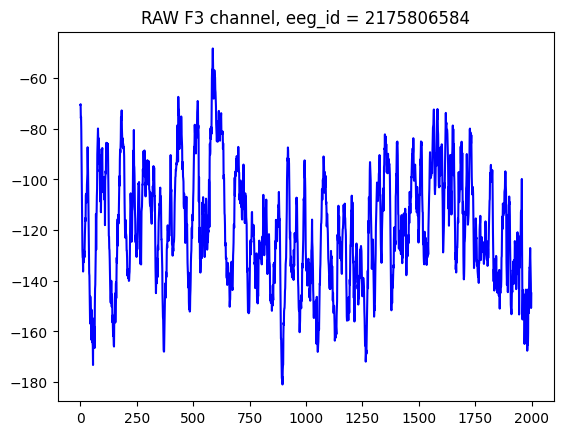

In [33]:
f3 = eeg_1628180742.iloc[:, 1]
plt.plot(f3, color = "blue")
plt.title('RAW F3 channel, eeg_id = 2175806584')

## 5. Preprocessing and Feature Engineering

### >> SHOWING FOR ONE EEG ID ONLY

### 5a. Denoising signals with wavelet transform

In [90]:
# denoising function using wavelet transform
def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def denoise(x, wavelet='haar', level=3):
    ret = {key:[] for key in x.columns}
    
    for pos in x.columns:
        coeff = pywt.wavedec(x[pos], wavelet, mode="per")
        sigma = (1/0.6745) * maddest(coeff[-level])

        uthresh = sigma * np.sqrt(2*np.log(len(x)))
        coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])

        ret[pos]=pywt.waverec(coeff, wavelet, mode='per')
    
    return pd.DataFrame(ret)

full_eeg_segments_denoised = denoise(eeg_1628180742, wavelet="db6")

Text(0.5, 1.0, 'F3 denoised channel, eeg_id = 1628180742')

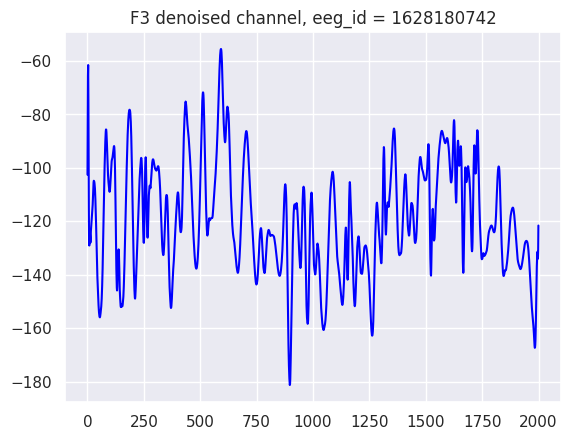

In [91]:
f3_denoise = full_eeg_segments_denoised.iloc[:, 1]
plt.plot(f3_denoise, color = "blue")
plt.title('F3 denoised channel, eeg_id = 1628180742')

### 5b. Discrete Wavelet Transform

In [39]:
def wavelet_decompose_channels(data, level, output=False):
  # take every x number of points using numpy's slicing (start:stop:step)
    data = data[0::2]

    data.columns.name='channel'

    # transpose the data
    data_t = data.transpose()

    # get the wavelet coefficients at each level in a list
    coeffs_list = wavedec(data_t.values, wavelet='db4', level=level)
    #print(len(coeffs_list))

    # make a list of the component names (later column rows)
    nums = list(range(1,level+1))
    names=[]
    for num in nums:
        names.append('D' + str(num))
    names.append('A' + str(nums[-1]))

  # reverse the names so it counts down
    names = names[::-1]  
    #print(names)

    i = 0
    wavelets = pd.DataFrame()
    for i in range(1, len(coeffs_list)):
    #for i, array in enumerate(coeffs_list):
        #print(i)
        array = coeffs_list[i]
        # turn into a dataframe and transpose
        level_df = pd.DataFrame(array)
        level_df.index = data.columns
        level_df['level'] = names[i]
        level_df= level_df.set_index('level', append=True)
        level_df=level_df.T
        # add the next levels df to another column
        wavelets = pd.concat([wavelets,level_df], axis=1, sort=True)

    # sort values along the channels
    wavelets = wavelets.sort_values(['channel', 'level'], axis=1)

    wavelets_cleaned = wavelets.dropna()

    return wavelets_cleaned

dwt_wavelets = wavelet_decompose_channels(full_eeg_segments_denoised, level=5, output=True)
dwt_wavelets.head(5)

channel        C3                                                     C4  \
level          D1         D2         D3         D4          D5        D1   
0       -1.168653  -0.922113 -16.431904   1.729444    1.263960 -0.013395   
1        0.461629  -5.975632 -52.035416   8.108521    5.226429  0.059562   
2        0.584536 -16.827389  18.371714  27.273756    2.402835 -0.132071   
3        1.097376  14.508818   2.464003  33.936295  -75.511528 -0.218302   
4       -2.738427  11.334391 -13.941605 -68.768005  100.558266  0.499544   

channel                                              ...        T5            \
level           D2         D3         D4         D5  ...        D1        D2   
0        -0.039757  -2.075855   0.092809  -0.035714  ...  0.208878 -1.500756   
1        -0.406191  -6.471304   0.756224  -1.376212  ...  0.331398 -4.480089   
2        -0.543072   6.827564  -6.399209 -30.827263  ... -0.417374  4.044893   
3        -2.386870  30.353439  46.873493 -32.884308  ... -0.389330 -5.593846   
4        10.831421 -35.643532  -0.501606  41.135738  ...  0.361800  6.911381   

channel                                       T6                        \
level          D3         D4        D5        D1         D2         D3   
0        1.379160  -0.040236 -0.550463  0.076974   0.001637  -2.792253   
1        4.717390   0.116284 -1.196724  0.145085  -0.297398  -8.629324   
2        5.422222   3.302198  7.962161 -0.111808   0.228981   9.851955   
3        3.553431 -13.999057 -4.874322 -0.271872  -3.189973  30.586849   
4       -8.816683 -25.561487  6.650605  0.569358  11.781376 -37.860664   

channel                        
level           D4         D5  
0         0.093788  -0.030820  
1         1.048637  -1.201875  
2        -2.671260 -25.274555  
3        46.646805 -22.696102  
4        12.961766  23.657623  

[5 rows x 100 columns]

### 5c. Mean Absolute Value

In [40]:
def MAV(data):
    # Initialize an empty DataFrame to store the means for each channel
    means = pd.DataFrame(index=data.index)

    # Iterate over each channel and calculate the mean across 'D1' to 'D5'
    for channel in data.columns.get_level_values(0).unique():
    # Calculate the mean for the current channel
        means[channel] = data[channel].abs().mean(axis=1)
    
    means.columns = [f"{col}_DT_MAV" for col in means.columns]
    
    return means


# Use the function with your data
example_wavelet_mean = MAV(dwt_wavelets)
example_wavelet_mean.head(5)

,C3_DT_MAV,C4_DT_MAV,Cz_DT_MAV,EKG_DT_MAV,F3_DT_MAV,F4_DT_MAV,F7_DT_MAV,F8_DT_MAV,Fp1_DT_MAV,Fp2_DT_MAV,Fz_DT_MAV,O1_DT_MAV,O2_DT_MAV,P3_DT_MAV,P4_DT_MAV,Pz_DT_MAV,T3_DT_MAV,T4_DT_MAV,T5_DT_MAV,T6_DT_MAV
0,4.303215,0.451506,3.675837,9.660343,6.125927,1.877822,3.416283,0.530166,4.195391,0.408017,4.736911,1.177387,1.373091,2.291655,1.347831,1.361712,4.043046,0.652390,0.735898,0.599094
1,14.361526,1.813898,11.555975,34.156017,20.804230,6.073800,11.839947,1.954473,13.497437,1.536668,15.231329,3.668135,4.166164,7.534365,4.108981,4.115509,12.873477,2.190234,2.168377,2.264464
2,13.092046,8.945836,12.213475,137.723633,24.755491,9.630498,13.402964,5.692088,14.335587,7.042911,15.429243,5.391077,3.755557,8.085393,9.539208,6.727666,10.488845,8.030675,4.229770,7.627711
3,25.503605,22.543283,29.347546,276.480408,41.186905,29.036976,28.363317,21.534100,49.010750,31.715771,36.192524,18.211792,8.016644,14.492014,23.972950,15.549558,14.354419,19.979229,5.681997,20.678320
4,39.468140,17.722368,27.508326,185.353149,34.144554,19.996222,40.008995,14.078211,41.369019,16.746332,25.572058,8.066412,12.269182,19.192621,23.851589,27.469120,32.232204,12.497320,9.660391,17.366158


### 5d. Mean Average Power

In [41]:
def MAVP(data):
    # Initialize an empty DataFrame to store the means for each channel
    means_abs = pd.DataFrame(index=data.index)

    # Iterate over each channel and calculate the mean across 'D1' to 'D5'
    for channel in data.columns.get_level_values(0).unique():
    # Calculate the mean for the current channel
        means_abs[channel] = (data[channel]**2).mean(axis = 1)
    
    means_abs.columns = [f"{col}_DT_MAVP" for col in means_abs.columns]
    
    return means_abs

example_wavelet_meanabs = MAVP(dwt_wavelets)
example_wavelet_meanabs.head(5)

,C3_DT_MAVP,C4_DT_MAVP,Cz_DT_MAVP,EKG_DT_MAVP,F3_DT_MAVP,F4_DT_MAVP,F7_DT_MAVP,F8_DT_MAVP,Fp1_DT_MAVP,Fp2_DT_MAVP,Fz_DT_MAVP,O1_DT_MAVP,O2_DT_MAVP,P3_DT_MAVP,P4_DT_MAVP,Pz_DT_MAVP,T3_DT_MAVP,T4_DT_MAVP,T5_DT_MAVP,T6_DT_MAVP
0,55.362415,0.864165,39.429966,201.813950,96.622726,6.681484,33.392765,1.139944,38.549328,0.385443,71.688560,2.640832,4.291650,13.452478,2.732650,3.274832,35.194538,0.674130,0.900522,1.562470
1,567.333923,8.902429,402.074493,2171.440186,974.840515,66.167130,340.257141,11.162666,396.234619,4.385751,727.043274,26.589306,42.652885,137.426605,28.382483,34.589752,361.231873,7.617607,8.776093,15.423775
2,274.130798,207.639603,274.741608,33236.519531,838.033325,157.825317,280.125824,80.602661,364.333557,104.865822,324.812927,44.412819,25.437918,67.923927,169.985550,105.373520,159.933426,124.691574,24.047272,148.612946
3,1414.288818,841.115601,1401.805054,178417.031250,3893.306641,1302.773071,1619.802002,779.074768,6302.035156,2075.030762,2440.835205,579.741882,93.263847,322.312988,978.017944,414.987488,331.356934,612.321289,52.760437,727.368530
4,3034.268066,616.086243,1295.115112,59049.281250,3015.894043,595.969849,3582.033691,313.325714,3554.109863,426.621246,1058.039185,115.405594,259.234955,566.229614,880.691895,1599.567017,2130.599609,263.877197,164.650421,460.049072


### 5e. Standard Deviation (STD)

In [42]:
def std_val(data):
    # Initialize an empty DataFrame to store the means for each channel
    std_vals = pd.DataFrame(index=data.index)

    # Iterate over each channel and calculate the mean across 'D1' to 'D5'
    for channel in data.columns.get_level_values(0).unique():
    # Calculate the mean for the current channel
        std_vals[channel] = data[channel].std(axis = 1)
    
    std_vals.columns = [f"{col}_DT_STD" for col in std_vals.columns]
    
    return std_vals

example_wavelet_std = std_val(dwt_wavelets)
example_wavelet_std.head(5)

,C3_DT_STD,C4_DT_STD,Cz_DT_STD,EKG_DT_STD,F3_DT_STD,F4_DT_STD,F7_DT_STD,F8_DT_STD,Fp1_DT_STD,Fp2_DT_STD,Fz_DT_STD,O1_DT_STD,O2_DT_STD,P3_DT_STD,P4_DT_STD,Pz_DT_STD,T3_DT_STD,T4_DT_STD,T5_DT_STD,T6_DT_STD
0,7.559439,0.930358,6.474781,12.056791,9.638258,2.485612,5.768360,1.074371,5.900017,0.615320,8.906230,1.805255,2.263216,3.644420,1.842642,1.599543,5.703421,0.911850,1.054979,1.265616
1,24.726936,2.891695,20.857458,45.119858,31.305719,7.728427,18.648771,3.323642,19.813194,2.083820,28.592438,5.729316,7.111102,11.740664,5.941148,5.517054,18.954861,3.045045,3.310139,3.910002
2,17.090469,14.535118,16.453691,151.300491,27.369881,13.925426,17.479351,9.773629,18.864685,11.046686,19.659492,7.188313,4.852400,8.812026,14.562589,10.286667,13.668195,11.636765,3.070173,13.023369
3,41.716145,31.053080,40.985535,470.555298,68.560501,39.087688,44.941463,31.132639,86.902435,50.269566,54.906868,24.133839,9.628525,18.664354,33.556664,22.400780,19.590574,27.347004,6.577187,27.906528
4,61.301460,27.509781,40.203197,270.675079,60.264164,27.251350,64.268593,19.704485,63.176964,22.944954,36.224323,11.762823,17.184807,26.604198,32.547874,43.351040,51.519455,18.159521,13.597571,23.851423


### 5f. Variance

In [43]:
def var_val(data):
    # Initialize an empty DataFrame to store the means for each channel
    var = pd.DataFrame(index=data.index)

    # Iterate over each channel and calculate the mean across 'D1' to 'D5'
    for channel in data.columns.get_level_values(0).unique():
    # Calculate the mean for the current channel
        var[channel] = data[channel].var(axis = 1)
    
    var.columns = [f"{col}_DT_VAR" for col in var.columns]
    
    return var

example_wavelet_var = var_val(dwt_wavelets)
example_wavelet_var.head(5)

,C3_DT_VAR,C4_DT_VAR,Cz_DT_VAR,EKG_DT_VAR,F3_DT_VAR,F4_DT_VAR,F7_DT_VAR,F8_DT_VAR,Fp1_DT_VAR,Fp2_DT_VAR,Fz_DT_VAR,O1_DT_VAR,O2_DT_VAR,P3_DT_VAR,P4_DT_VAR,Pz_DT_VAR,T3_DT_VAR,T4_DT_VAR,T5_DT_VAR,T6_DT_VAR
0,57.145111,0.865565,41.922787,145.366211,92.896011,6.178268,33.273975,1.154273,34.810200,0.378619,79.320938,3.258947,5.122149,13.281800,3.395330,2.558539,32.529007,0.831470,1.112981,1.601784
1,611.421387,8.361903,435.033569,2035.801636,980.048035,59.728588,347.776672,11.046597,392.562653,4.342308,817.527466,32.825058,50.567776,137.843185,35.297241,30.437887,359.286713,9.272298,10.957022,15.288117
2,292.084137,211.269669,270.723938,22891.839844,749.110413,193.917496,305.527710,95.523827,355.876343,122.029274,386.495636,51.671848,23.545782,77.651810,212.068985,105.815514,186.819550,135.414307,9.425961,169.608124
3,1740.236694,964.293762,1679.814087,221422.281250,4700.542480,1527.847290,2019.735229,969.241211,7552.033203,2527.029053,3014.764160,582.442200,92.708481,348.358154,1126.049683,501.794922,383.790588,747.858582,43.259388,778.774292
4,3757.868896,756.788086,1616.296997,73264.992188,3631.769287,742.636047,4130.451660,388.266724,3991.328613,526.470947,1312.201660,138.363998,295.317596,707.783325,1059.364014,1879.312744,2654.254150,329.768188,184.893951,568.890381


### 5g. Ratio channels

In [45]:
def ratio_channels(epoch_data):
    # Initialize an empty DataFrame to store the ratio values for each pair of channels
    ratio_data = pd.DataFrame(index=epoch_data.index)
    
    # Iterate over each pair of adjacent channels
    for i in range(len(epoch_data.columns) - 1):
        channel1 = epoch_data.columns[i]
        channel2 = epoch_data.columns[i + 1]
        
       # Calculate the ratio between the values of the two channels
        ratio_data[f"{channel1}-{channel2}_Ratio"] = epoch_data[channel1] / epoch_data[channel2]
    
    return ratio_data

# Example usage:
example_ratio_data = ratio_channels(dwt_wavelets)
example_ratio_data.head(5)

,"('C3', 'D1')-('C3', 'D2')_Ratio","('C3', 'D2')-('C3', 'D3')_Ratio","('C3', 'D3')-('C3', 'D4')_Ratio","('C3', 'D4')-('C3', 'D5')_Ratio","('C3', 'D5')-('C4', 'D1')_Ratio","('C4', 'D1')-('C4', 'D2')_Ratio","('C4', 'D2')-('C4', 'D3')_Ratio","('C4', 'D3')-('C4', 'D4')_Ratio","('C4', 'D4')-('C4', 'D5')_Ratio","('C4', 'D5')-('Cz', 'D1')_Ratio",...,"('T4', 'D5')-('T5', 'D1')_Ratio","('T5', 'D1')-('T5', 'D2')_Ratio","('T5', 'D2')-('T5', 'D3')_Ratio","('T5', 'D3')-('T5', 'D4')_Ratio","('T5', 'D4')-('T5', 'D5')_Ratio","('T5', 'D5')-('T6', 'D1')_Ratio","('T6', 'D1')-('T6', 'D2')_Ratio","('T6', 'D2')-('T6', 'D3')_Ratio","('T6', 'D3')-('T6', 'D4')_Ratio","('T6', 'D4')-('T6', 'D5')_Ratio"
0,1.267365,0.056117,-9.501266,1.368274,-94.360077,0.336923,0.019152,-22.366915,-2.598668,0.024336,...,-2.193929,-0.139182,-1.088166,-34.277187,0.073094,-7.151267,47.028843,-0.000586,-29.771837,-3.043112
1,-0.077252,0.114838,-6.417374,1.551446,87.747765,-0.146636,0.062768,-8.557394,-0.549496,2.890229,...,-7.725571,-0.073971,-0.949697,40.567871,-0.097169,-8.248455,-0.487846,0.034464,-8.229085,-0.872501
2,-0.034737,-0.915940,0.673604,11.350656,-18.193443,0.243193,-0.079541,-1.066939,0.207583,-28.673044,...,54.777119,-0.103186,0.745984,1.642004,0.414736,-71.212837,-0.488285,0.023242,-3.688130,0.105690
3,0.075635,5.888311,0.072607,-0.449419,345.904510,0.091459,-0.078636,0.647561,-1.425406,-17.073261,...,90.142609,0.069600,-1.574210,-0.253834,2.872001,17.928768,0.085227,-0.104292,0.655712,-2.055278
4,-0.241603,-0.812990,0.202734,-0.683862,201.300064,0.046120,-0.303882,71.058754,-0.012194,-12.850820,...,24.547171,0.052348,-0.783898,0.344921,-3.843483,11.680891,0.048327,-0.311177,-2.920949,0.547890


### 5h. Shannon Entropy

In [49]:
def shannon_entropy(data):
    # Initialize an empty DataFrame to store the entropy values for each channel
    entropy_df = pd.DataFrame(index=data.index)

    # Iterate over each channel and calculate the entropy across 'D1' to 'D5'
    for channel in data.columns.get_level_values(0).unique():
        # Calculate the entropy for the current channel
        entropy_values = data[channel].apply(lambda x: entropy(x.abs(), base=2), axis=1)
        entropy_df[channel + '_entropy'] = entropy_values

    return entropy_df

# Example usage:
example_wavelet_entropy = shannon_entropy(dwt_wavelets)
example_wavelet_entropy.head(5)

,C3_entropy,C4_entropy,Cz_entropy,EKG_entropy,F3_entropy,F4_entropy,F7_entropy,F8_entropy,Fp1_entropy,Fp2_entropy,Fz_entropy,O1_entropy,O2_entropy,P3_entropy,P4_entropy,Pz_entropy,T3_entropy,T4_entropy,T5_entropy,T6_entropy
0,1.252605,0.541739,1.214261,1.416239,1.457067,1.616104,1.220496,0.669025,1.602283,1.483406,1.116086,1.688209,1.510387,1.400440,1.930775,1.834220,1.658323,1.867225,1.774575,0.460535
1,1.312468,1.307389,1.185091,1.668625,1.636574,1.722909,1.518421,1.244164,1.520696,1.739528,1.120728,1.651068,1.417523,1.473454,1.704430,1.671224,1.589659,1.778806,1.624163,1.178515
2,1.780335,1.287453,1.720821,1.698941,2.061615,1.866622,1.895631,1.251476,1.706250,1.597160,1.978797,1.874555,1.750265,2.292527,1.625827,1.526094,1.908851,1.698264,2.020530,1.235425
3,1.481719,1.689830,1.807258,1.250264,1.398490,1.910934,1.508130,1.689098,1.133029,1.549731,1.629618,1.717056,1.892197,1.849544,1.797232,1.636022,1.821067,1.808504,1.861018,1.695469
4,1.618100,1.497458,1.707973,1.759208,1.097501,1.957350,1.469184,1.844220,1.579937,1.878577,1.881296,1.647084,1.615368,1.871141,1.853587,1.579858,1.507910,1.823439,1.781871,1.881405


### 5i. Continous Wavelet Transform

In [31]:
sample_rate = 200

def cwt_wavelet_decompose(data, freq, waveletname):
    
    scales = np.arange(0.25, (freq/20)+0.25, 0.1)
    frequencies = scale2frequency(waveletname, scales) / (freq*0.0002)  # 100 Hz sampling is 0.01
    
    # transpose the data
    data_t = data.transpose()
    
    # get the wavelet coefficients at each level in a list
    coeffs_list = cwt(data_t.values, scales, waveletname)

    decom_wavelets = pd.DataFrame(coeffs_list[0][:,0,:], index =np.round(frequencies, 2)).T
    
    
    return decom_wavelets

print('Continous Wavelets')
continous_wavelets = cwt_wavelet_decompose(full_eeg_segments_denoised, sample_rate, 'morl')
continous_wavelets

Continous Wavelets


,81.25,58.04,45.14,36.93,31.25,27.08,23.90,21.38,19.35,17.66,...,2.20,2.17,2.15,2.13,2.10,2.08,2.06,2.04,2.02,2.00
0,0.000204,0.857369,-0.772811,2.560114,-13.552676,0.009999,10.258551,-1.988405,-16.799723,-14.605639,...,-2.656075,-16.292847,-13.598251,-11.004535,-4.030211,-0.753133,-15.418056,-12.557753,-9.479839,-2.523796
1,-0.001162,-0.510314,1.197703,1.342295,-1.618639,-0.561723,-0.561069,-5.796064,-1.917546,10.246495,...,-22.258404,-31.303864,-30.653996,-25.246927,-22.965218,-21.469683,-30.709150,-27.200741,-25.285713,-22.969482
2,0.000113,0.269564,-0.778072,-1.206993,1.981063,-0.038122,0.299801,1.985030,4.981507,2.270863,...,-34.527733,-36.865128,-36.666416,-34.998409,-35.216625,-32.093803,-36.342026,-35.626766,-33.849163,-33.657127
3,0.000305,0.350860,-0.636746,-0.173904,-1.598859,0.118910,2.197027,1.509606,-1.435669,-3.931871,...,-35.692284,-30.206961,-32.846806,-34.627579,-35.645229,-35.785191,-32.474575,-35.030178,-35.655842,-36.061924
4,-0.000082,0.032162,0.026404,0.319720,-1.256652,-0.040858,1.040958,-0.433879,-1.406989,0.519351,...,-26.421427,-16.286404,-21.580414,-25.778322,-27.357456,-31.412457,-22.951128,-24.860016,-29.169397,-32.499554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.000002,0.101236,-0.147094,0.090372,-0.979068,-0.001920,0.807494,-0.141156,-1.298272,-0.997098,...,-30.793383,-62.554451,-57.507183,-52.367069,-46.417072,-40.633163,-70.144249,-65.580803,-60.870193,-55.500683
1996,-0.000119,-0.140609,0.327641,0.347366,-0.203860,-0.056368,-0.361172,-0.826219,-0.394397,0.704892,...,-67.405640,-85.080063,-83.334747,-80.601151,-77.461716,-74.121925,-86.990105,-85.335632,-83.234070,-80.532845
1997,0.000003,0.048396,-0.161218,-0.292578,0.553927,-0.006756,-0.004780,0.680585,1.661323,1.618931,...,-86.642372,-83.914253,-85.760841,-86.952721,-88.490540,-87.851822,-82.787369,-84.772102,-88.071213,-88.873337
1998,-0.000588,-0.009309,0.022905,-0.082042,-0.520204,-0.149652,-4.004529,-6.065325,-7.505033,-8.502037,...,-81.247078,-57.832405,-63.399837,-72.606377,-76.308647,-79.682892,-59.572880,-64.831367,-69.553902,-73.718002


## 6. Combining all features together

In [51]:
def eeg_feature(data):
    
    wavelet_mean = MAV(data)
    wavelet_meanabs = MAVP(data)
    wavelet_std = std_val(data)
    wavelet_var = var_val(data)
    wavelet_ratio = ratio_channels(data)
    wavelet_entropy = shannon_entropy(data)
    
    wavelet_statistics = pd.concat([data, wavelet_mean, wavelet_meanabs, wavelet_std, wavelet_var, wavelet_ratio, wavelet_entropy], axis=1)
    
    return wavelet_statistics

In [52]:
dwt_wavelets_features = eeg_feature(dwt_wavelets)
print("Total dimensions of 'dwt_wavelets_features': ", dwt_wavelets_features.shape)
dwt_wavelets_features.head(5)

Total dimensions of 'dwt_wavelets_features':  (38, 299)


,"(C3, D1)","(C3, D2)","(C3, D3)","(C3, D4)","(C3, D5)","(C4, D1)","(C4, D2)","(C4, D3)","(C4, D4)","(C4, D5)",...,Fz_entropy,O1_entropy,O2_entropy,P3_entropy,P4_entropy,Pz_entropy,T3_entropy,T4_entropy,T5_entropy,T6_entropy
0,-1.168653,-0.922113,-16.431904,1.729444,1.263960,-0.013395,-0.039757,-2.075855,0.092809,-0.035714,...,1.116086,1.688209,1.510387,1.400440,1.930775,1.834220,1.658323,1.867225,1.774575,0.460535
1,0.461629,-5.975632,-52.035416,8.108521,5.226429,0.059562,-0.406191,-6.471304,0.756224,-1.376212,...,1.120728,1.651068,1.417523,1.473454,1.704430,1.671224,1.589659,1.778806,1.624163,1.178515
2,0.584536,-16.827389,18.371714,27.273756,2.402835,-0.132071,-0.543072,6.827564,-6.399209,-30.827263,...,1.978797,1.874555,1.750265,2.292527,1.625827,1.526094,1.908851,1.698264,2.020530,1.235425
3,1.097376,14.508818,2.464003,33.936295,-75.511528,-0.218302,-2.386870,30.353439,46.873493,-32.884308,...,1.629618,1.717056,1.892197,1.849544,1.797232,1.636022,1.821067,1.808504,1.861018,1.695469
4,-2.738427,11.334391,-13.941605,-68.768005,100.558266,0.499544,10.831421,-35.643532,-0.501606,41.135738,...,1.881296,1.647084,1.615368,1.871141,1.853587,1.579858,1.507910,1.823439,1.781871,1.881405


This data combines ALL features: DWT, MAV, MAVP, STD, VAR, RATIO, ENTROPY

## 7. Feature Selection

### 7a. Variance Threshold Method

Selecting features based on variance of data (var > 0.8)


In [56]:
sel = VarianceThreshold(threshold=.8) # using 0.8 in the context of seizures to preserve high brain activity

dwt_wavelets_features.columns = dwt_wavelets_features.columns.astype(str)

sel.fit(dwt_wavelets_features)

# get boolian list of what is kept and what not
keep_bool = sel.get_support()
# get index of false values
remove_index = [i for i, x in enumerate(keep_bool) if not x]

# merge multiindex feature labels into 1 label list
feat_labels = dwt_wavelets_features.columns
remove_list = list(feat_labels[remove_index])

print('Features and Channels Removed')
print(remove_list)

Features and Channels Removed
["('C4', 'D1')", "('F8', 'D1')", "('Fp2', 'D1')", "('O1', 'D1')", "('O2', 'D1')", "('Pz', 'D1')", "('T3', 'D1')", "('T4', 'D1')", "('T5', 'D1')", "('T6', 'D1')", "('F4', 'D1')-('F4', 'D2')_Ratio", "('F8', 'D1')-('F8', 'D2')_Ratio", "('Fp2', 'D1')-('Fp2', 'D2')_Ratio", "('Fz', 'D1')-('Fz', 'D2')_Ratio", "('O2', 'D1')-('O2', 'D2')_Ratio", "('P3', 'D2')-('P3', 'D3')_Ratio", "('Pz', 'D1')-('Pz', 'D2')_Ratio", "('T4', 'D1')-('T4', 'D2')_Ratio", "('T6', 'D2')-('T6', 'D3')_Ratio", 'C3_entropy', 'C4_entropy', 'Cz_entropy', 'EKG_entropy', 'F3_entropy', 'F4_entropy', 'F7_entropy', 'F8_entropy', 'Fp1_entropy', 'Fp2_entropy', 'Fz_entropy', 'O1_entropy', 'O2_entropy', 'P3_entropy', 'P4_entropy', 'Pz_entropy', 'T3_entropy', 'T4_entropy', 'T5_entropy', 'T6_entropy']


In [57]:
dwt_wavelets_features_removed = dwt_wavelets_features.drop(remove_list, axis = 1)
dwt_wavelets_features_removed.head(5)

,"('C3', 'D1')","('C3', 'D2')","('C3', 'D3')","('C3', 'D4')","('C3', 'D5')","('C4', 'D2')","('C4', 'D3')","('C4', 'D4')","('C4', 'D5')","('Cz', 'D1')",...,"('T4', 'D4')-('T4', 'D5')_Ratio","('T4', 'D5')-('T5', 'D1')_Ratio","('T5', 'D1')-('T5', 'D2')_Ratio","('T5', 'D2')-('T5', 'D3')_Ratio","('T5', 'D3')-('T5', 'D4')_Ratio","('T5', 'D4')-('T5', 'D5')_Ratio","('T5', 'D5')-('T6', 'D1')_Ratio","('T6', 'D1')-('T6', 'D2')_Ratio","('T6', 'D3')-('T6', 'D4')_Ratio","('T6', 'D4')-('T6', 'D5')_Ratio"
0,-1.168653,-0.922113,-16.431904,1.729444,1.263960,-0.039757,-2.075855,0.092809,-0.035714,-1.467533,...,0.190432,-2.193929,-0.139182,-1.088166,-34.277187,0.073094,-7.151267,47.028843,-29.771837,-3.043112
1,0.461629,-5.975632,-52.035416,8.108521,5.226429,-0.406191,-6.471304,0.756224,-1.376212,-0.476160,...,0.041563,-7.725571,-0.073971,-0.949697,40.567871,-0.097169,-8.248455,-0.487846,-8.229085,-0.872501
2,0.584536,-16.827389,18.371714,27.273756,2.402835,-0.543072,6.827564,-6.399209,-30.827263,1.075130,...,0.306141,54.777119,-0.103186,0.745984,1.642004,0.414736,-71.212837,-0.488285,-3.688130,0.105690
3,1.097376,14.508818,2.464003,33.936295,-75.511528,-2.386870,30.353439,46.873493,-32.884308,1.926071,...,-0.979284,90.142609,0.069600,-1.574210,-0.253834,2.872001,17.928768,0.085227,0.655712,-2.055278
4,-2.738427,11.334391,-13.941605,-68.768005,100.558266,10.831421,-35.643532,-0.501606,41.135738,-3.201021,...,1.168025,24.547171,0.052348,-0.783898,0.344921,-3.843483,11.680891,0.048327,-2.920949,0.547890


### 7b. Correlation matrix

Examining highly correlated features in a channel (eg. C3)

Features removed:  ['C3_DT_MAVP', 'C3_DT_STD', 'C3_DT_VAR']


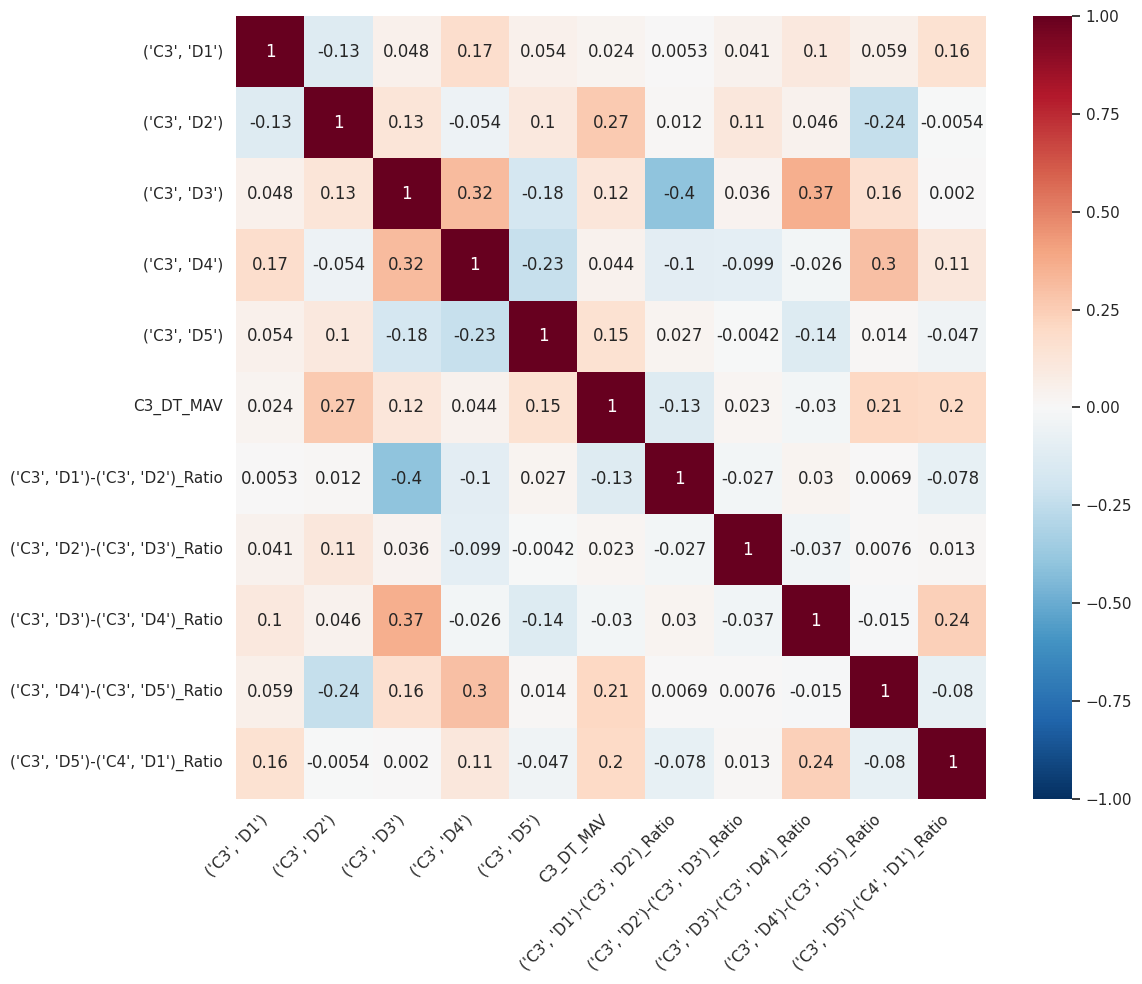

In [60]:
# examine for one channel (eg. C3)
dwt_wavelets_features_removed_C3 = dwt_wavelets_features_removed[["('C3', 'D1')","('C3', 'D2')", "('C3', 'D3')",
 "('C3', 'D4')","('C3', 'D5')",'C3_DT_MAV','C3_DT_MAVP', 'C3_DT_STD','C3_DT_VAR',"('C3', 'D1')-('C3', 'D2')_Ratio",
 "('C3', 'D2')-('C3', 'D3')_Ratio","('C3', 'D3')-('C3', 'D4')_Ratio","('C3', 'D4')-('C3', 'D5')_Ratio",
 "('C3', 'D5')-('C4', 'D1')_Ratio"]]


# Assuming dwt_wavelets_features_selected_C3 is already defined as shown previously
correlations = dwt_wavelets_features_removed_C3.corr()

# Set the correlation threshold
threshold = 0.8

# Finding features with correlation greater than the threshold
# np.triu: consider upper triangle of matrix, to avoid double counting pairs
upper = correlations.where(np.triu(np.ones(correlations.shape), k=1).astype(bool))

# Select columns to drop based on threshold
to_drop = [column for column in upper.columns if any(upper[column].abs() > threshold)]

# Revised DataFrame with highly correlated features dropped
revised_features = dwt_wavelets_features_removed_C3.drop(columns=to_drop)
print("Features removed: ", list(to_drop))

# Show the updated correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(revised_features.corr(), vmin=-1, vmax=1, cmap='RdBu_r', annot=True)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Examining highly correlated features in a channel (eg. O1)

Features removed for O1 channel:  ['O1_DT_MAVP', 'O1_DT_STD', 'O1_DT_VAR']


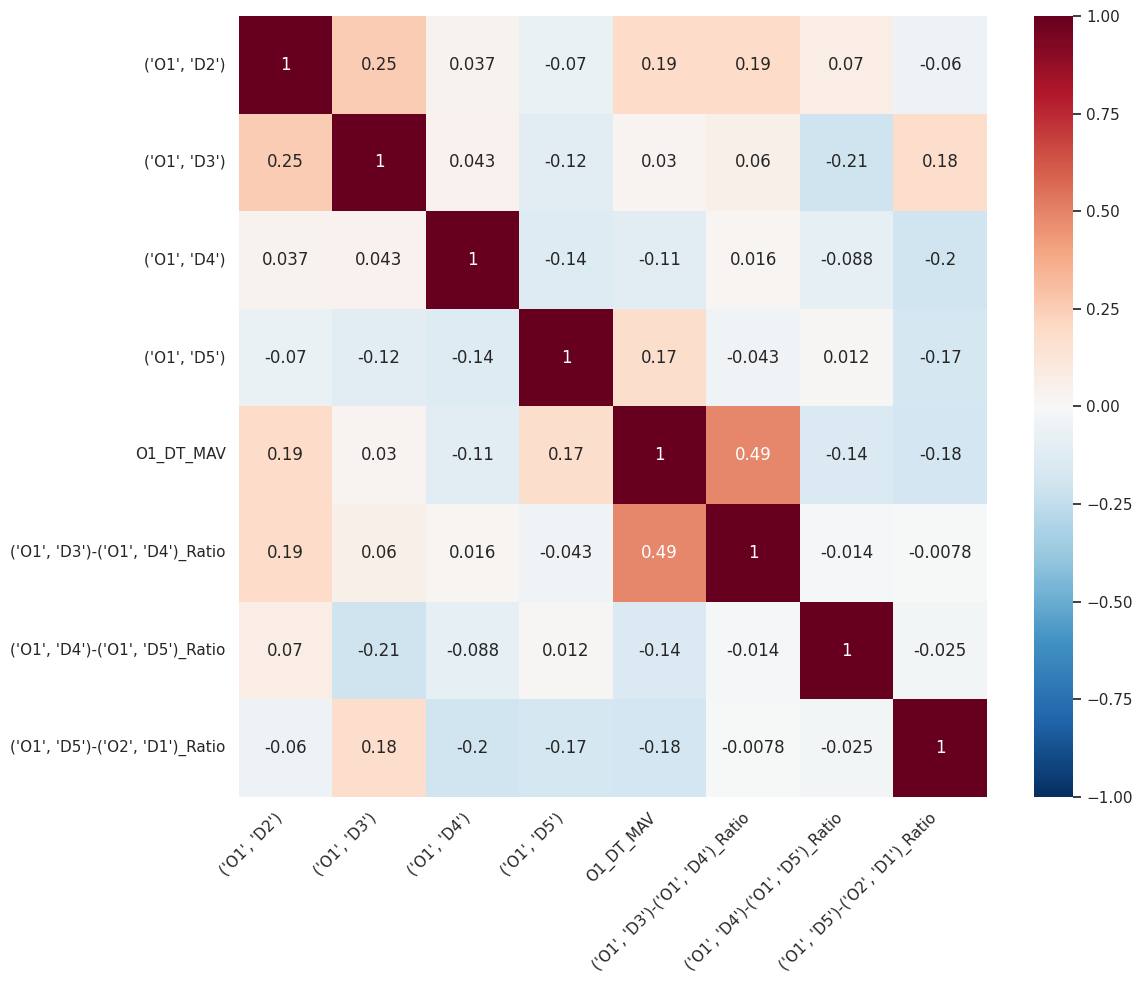

In [61]:
# examine for one channel (eg. O1)
dwt_wavelets_features_removed_O1 = dwt_wavelets_features_removed[["('O1', 'D2')","('O1', 'D3')", "('O1', 'D4')", "('O1', 'D5')", 'O1_DT_MAV','O1_DT_MAVP','O1_DT_STD','O1_DT_VAR',
"('O1', 'D3')-('O1', 'D4')_Ratio","('O1', 'D4')-('O1', 'D5')_Ratio","('O1', 'D5')-('O2', 'D1')_Ratio"]]

correlations2 = dwt_wavelets_features_removed_O1.corr()

upper = correlations2.where(np.triu(np.ones(correlations2.shape), k=1).astype(bool))

# Select columns to drop based on threshold
to_drop = [column for column in upper.columns if any(upper[column].abs() > threshold)]

# Revised DataFrame with highly correlated features dropped
revised_features2 = dwt_wavelets_features_removed_O1.drop(columns=to_drop)
print("Features removed for O1 channel: ", list(to_drop))

# Show the updated correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(revised_features2.corr(), vmin=-1, vmax=1, cmap='RdBu_r', annot=True)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

General features to remove: ['DT_MAVP', 'DT_STD', 'DT_VAR']

## 8. Preparing data for CNN model 

In [ ]:
import pandas as pd
import numpy as np
import pywt
from scipy.stats import entropy

def create_data_loader(eeg_ids, eeg_data_dir, train_data, segment_length=10):
    """
    Create a data loader function to extract 10-second EEG segments for specified EEG IDs.
    Args:
    - eeg_ids (list): List of EEG IDs for which segments need to be extracted.
    - eeg_data_dir (str): Directory path where EEG data files are stored.
    - train_data (DataFrame): DataFrame containing training data with EEG labels and offsets.
    - segment_length (int): Length of EEG segments in seconds.
    Returns:
    - data_loader (generator): Generator function to yield EEG segments along with target labels.
    """
    def data_loader():
        for eeg_id in eeg_ids:
            # Load EEG data for the current EEG ID
            eeg_data_path = f"{eeg_data_dir}/{eeg_id}.parquet"
            example = pd.read_parquet(eeg_data_path)
            
            # Filter training data for the current EEG ID
            train_eegid = train_data[train_data['eeg_id'] == eeg_id]
            target_labels = train_eegid.iloc[0][['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']]
            
            offset_values_list = train_eegid['eeg_label_offset_seconds'].tolist()
            print("Number of offset subsamples for EEG ID", eeg_id, ":", len(offset_values_list))
            
            # Extract 10-second EEG segments along with target labels
            for offset in offset_values_list:
                start_index = int(offset) * 200
                end_index = start_index + (segment_length * 200)
                
                # Extract EEG segment
                eeg_segment = example.iloc[start_index:end_index].reset_index(drop=True)
                
                # Denoise and feature extraction
                denoised_segment = denoise(eeg_segment, wavelet="db8")
                dwt_wavelets = wavelet_decompose_channels(denoised_segment, level=5, output=True)
                features = eeg_feature(dwt_wavelets)
                
                # Drop selected features
                remove_list = ["('C4', 'D1')", "('F8', 'D1')", "('Fp2', 'D1')", "('O1', 'D1')", "('O2', 'D1')", "('Pz', 'D1')", "('T3', 'D1')", "('T4', 'D1')", "('T5', 'D1')", "('T6', 'D1')", "('F4', 'D1')-('F4', 'D2')_Ratio", "('F8', 'D1')-('F8', 'D2')_Ratio", "('Fp2', 'D1')-('Fp2', 'D2')_Ratio", "('Fz', 'D1')-('Fz', 'D2')_Ratio", "('O2', 'D1')-('O2', 'D2')_Ratio", "('P3', 'D2')-('P3', 'D3')_Ratio", "('Pz', 'D1')-('Pz', 'D2')_Ratio", "('T4', 'D1')-('T4', 'D2')_Ratio", "('T6', 'D2')-('T6', 'D3')_Ratio", 'C3_entropy', 'C4_entropy', 'Cz_entropy', 'EKG_entropy', 'F3_entropy', 'F4_entropy', 'F7_entropy', 'F8_entropy', 'Fp1_entropy', 'Fp2_entropy', 'Fz_entropy', 'O1_entropy', 'O2_entropy', 'P3_entropy', 'P4_entropy', 'Pz_entropy', 'T3_entropy', 'T4_entropy', 'T5_entropy', 'T6_entropy"]
                features_cleaned = features.drop(remove_list, axis=1, errors='ignore')
                
                # Yield EEG segment features along with target labels
                yield features_cleaned, target_labels, eeg_id
    
    return data_loader

# Example usage:
eeg_ids = sample_ids
eeg_data_dir = "/kaggle/input/hms-harmful-brain-activity-classification/train_eegs"
train_data = train  # Assuming 'train' is your DataFrame containing training data
segment_length = 10  # 10-second EEG segments
loader = create_data_loader(eeg_ids, eeg_data_dir, train_data, segment_length)


## 9. CNN-LSTM model

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset

def prepare_data(loader, test_size=0.2, random_state=42):
    eeg_data = []
    labels = []
    
    for eeg_segment, target_labels, eeg_id in loader():
        # Flatten EEG data for simplicity, CNN will expect 3D data: (batch, channels, seq_length)
        eeg_data.append(eeg_segment.reshape(eeg_segment.shape[0], -1))
        labels.append(target_labels)
    
    # Convert lists to numpy arrays
    eeg_data = np.array(eeg_data, dtype=np.float32)
    labels = np.array(labels, dtype=np.float32)
    
    # Shuffle and split the data
    X_train, X_test, y_train, y_test = train_test_split(
        eeg_data, labels, test_size=test_size, random_state=random_state)
    
    # Convert to PyTorch tensors
    train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
    test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
    
    # Create data loaders
    train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=64, shuffle=False)
    
    return train_loader, test_loader


In [ ]:
import torch.nn as nn

class CNNLSTM(nn.Module):
    def __init__(self):
        super(CNNLSTM, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
        )
        self.lstm = nn.LSTM(input_size=32, hidden_size=64, num_layers=1, batch_first=True)
        self.fc = nn.Linear(64, 6)  # Assuming 6 types of votes as output
    
    def forward(self, x):
        x = self.cnn(x)
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :])  # Take the output of the last LSTM sequence
        return x


In [ ]:
import torch.optim as optim

def train_model(model, train_loader, test_loader, epochs=10):
    criterion = nn.KLDivLoss(log_target=True)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    for epoch in range(epochs):
        model.train()
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
        
        # Evaluate the model
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for data, target in test_loader:
                output = model(data)
                test_loss += criterion(output, target).item()
        
        print(f'Epoch {epoch+1}, Test Loss: {test_loss / len(test_loader)}')

# Prepare and load your data
# Assuming loader() is defined somewhere that loads your data
train_loader, test_loader = prepare_data(loader)

# Initialize model and train
model = CNNLSTM()
train_model(model, train_loader, test_loader)


In [ ]:
import matplotlib.pyplot as plt

# Store losses from the train_model function
train_losses, test_losses = [], []

# Plotting
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend()
plt.show()
